<a href="https://colab.research.google.com/github/das-apratim/GeospatialDeepLearning/blob/main/GeospatialMachineLearning_Kalman_Filter_GPS_Data_XY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geospatial Machine Learning Series - Kalman Filter
## Implimentation of Kalmal Filter to remove noise from GPS Data

### Install and Import Dependencies

In [66]:
!pip install pykalman
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import pandas as pd

### Load Some Sample GPS Data..
#### Download Data from https://www.openstreetmap.org/traces/
#### Create Dataframe with the GPX Data

In [67]:
data = pd.read_csv('/content/track_points_sample.csv')
dev = np.std(data['total_noise_meters'])
print(f"Standard Deviation {dev}")
data.head()


Standard Deviation 54.71680340237639


,latitude,longitude,timestamp,accuracy,speed,altitude,source,signal_loss,true_latitude,true_longitude,noise_latitude,noise_longitude,bias_latitude,bias_longitude,drift_latitude,drift_longitude,random_noise_latitude,random_noise_longitude,total_noise_meters
0,17.385156,78.486249,2025-03-07 06:31:02.093699000,5.787634,12.099155,98.646324,Route,False,17.385132,78.486259,2.542276,-1.060838,1.432685,2.277351,0.068995,-0.029406,1.040595,-3.308784,2.754731
1,17.385312,78.485897,2025-03-07 06:31:05.341573874,6.202485,7.078153,50.973008,Route,False,17.385337,78.485921,-2.653606,-2.541300,1.432685,2.277351,0.135300,-0.064458,-4.221592,-4.754193,3.674212
2,17.385600,78.485651,2025-03-07 06:31:08.589448748,3.242677,6.594637,29.510886,Route,False,17.385621,78.485649,-2.192015,0.220464,1.432685,2.277351,0.202075,-0.098605,-3.826775,-1.958282,2.203074
3,17.386011,78.485476,2025-03-07 06:31:11.837323622,3.892860,7.463497,325.877233,Route,False,17.385984,78.485450,2.894622,2.726185,1.432685,2.277351,0.265400,-0.138792,1.196536,0.587626,3.976295
4,17.386424,78.485269,2025-03-07 06:31:15.085198496,6.817408,6.924571,364.500038,Route,False,17.386391,78.485284,3.505612,-1.615750,1.432685,2.277351,0.331789,-0.173685,1.741138,-3.719416,3.860047


In [68]:
import plotly.express as px


center_lat = data['latitude'].mean()
center_lon = data['longitude'].mean()


fig = px.scatter_mapbox(data,
                        lat="latitude",  ## Y-coord
                        lon="longitude", ## X-coord
                        zoom=10,
                        height=600,
                        center=dict(lat=center_lat, lon=center_lon),
                        color_discrete_sequence=["red"],
                        size_max = [0.1] * len(data))
 # Set marker size to 10 for all points


fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()



## Init Kalman Filter parameters
### Setup Initial Values

In [69]:
# Constant Time
dt = 1.0

# State transition matrix
transition_matrix = np.array([
    [ dt, 0],
    [0, dt],
])

# Observation matrix - we only observe position, not velocity
observation_matrix = np.array([
    [1, 0],
    [0, 1]
])

# Initial state covariance - our uncertainty about the initial state
initial_state_covariance = np.eye(2) * 10

# Process noise - how much randomness in the process (affects state evolution)
# Smaller process noise = smoother but less responsive tracking
process_noise = np.eye(2)
process_noise[0, 0] = 1.0  # position noise x
process_noise[1, 1] = 1.0  # position noise y


# Observation noise - how noisy our measurements are
# Higher = less trust in measurements
observation_noise = np.eye(2) * 3
# Initial state - our best guess of starting position and velocity
initial_state_mean = np.array([data['longitude'][0], data['latitude'][0]])

### Kalman filtering

#### Setting Up the filter

In [70]:
# Create the Kalman Filter
kf = KalmanFilter(
    transition_matrices=transition_matrix,
    observation_matrices=observation_matrix,
    initial_state_mean=initial_state_mean,
    initial_state_covariance=initial_state_covariance,
    observation_covariance=observation_noise,
    transition_covariance=process_noise
)

#### Filter the Noisy Data

In [71]:
# Transform the measurements into the format expected by pykalman
# We need an (n_steps, n_dim_obs) array
measurements = np.column_stack([data['longitude'], data['latitude']])

# Run the Kalman Filter
filtered_state_means, filtered_state_covariances = kf.filter(measurements)

#### Extract the filtered positions (the first two columns of the state)


In [72]:
filtered_x = filtered_state_means[:, 0]
filtered_y = filtered_state_means[:, 1]

# Add the filtered positions to our dataframe
data['filtered_x'] = filtered_x
data['filtered_y'] = filtered_y

# Calculate position errors

# Calculate position errors
data['measured_error'] = np.sqrt((data['longitude'] - data['true_longitude'])**2 +
                                (data['latitude'] - data['true_latitude'])**2)
data['filtered_error'] = np.sqrt((data['filtered_x'] - data['true_longitude'])**2 +
                               (data['filtered_y'] - data['true_latitude'])**2)

#### Plot the Data and visualise

Average GPS measurement error: 0.00 meters
Average Kalman filter error: 0.00 meters
Error reduction: -140.07%


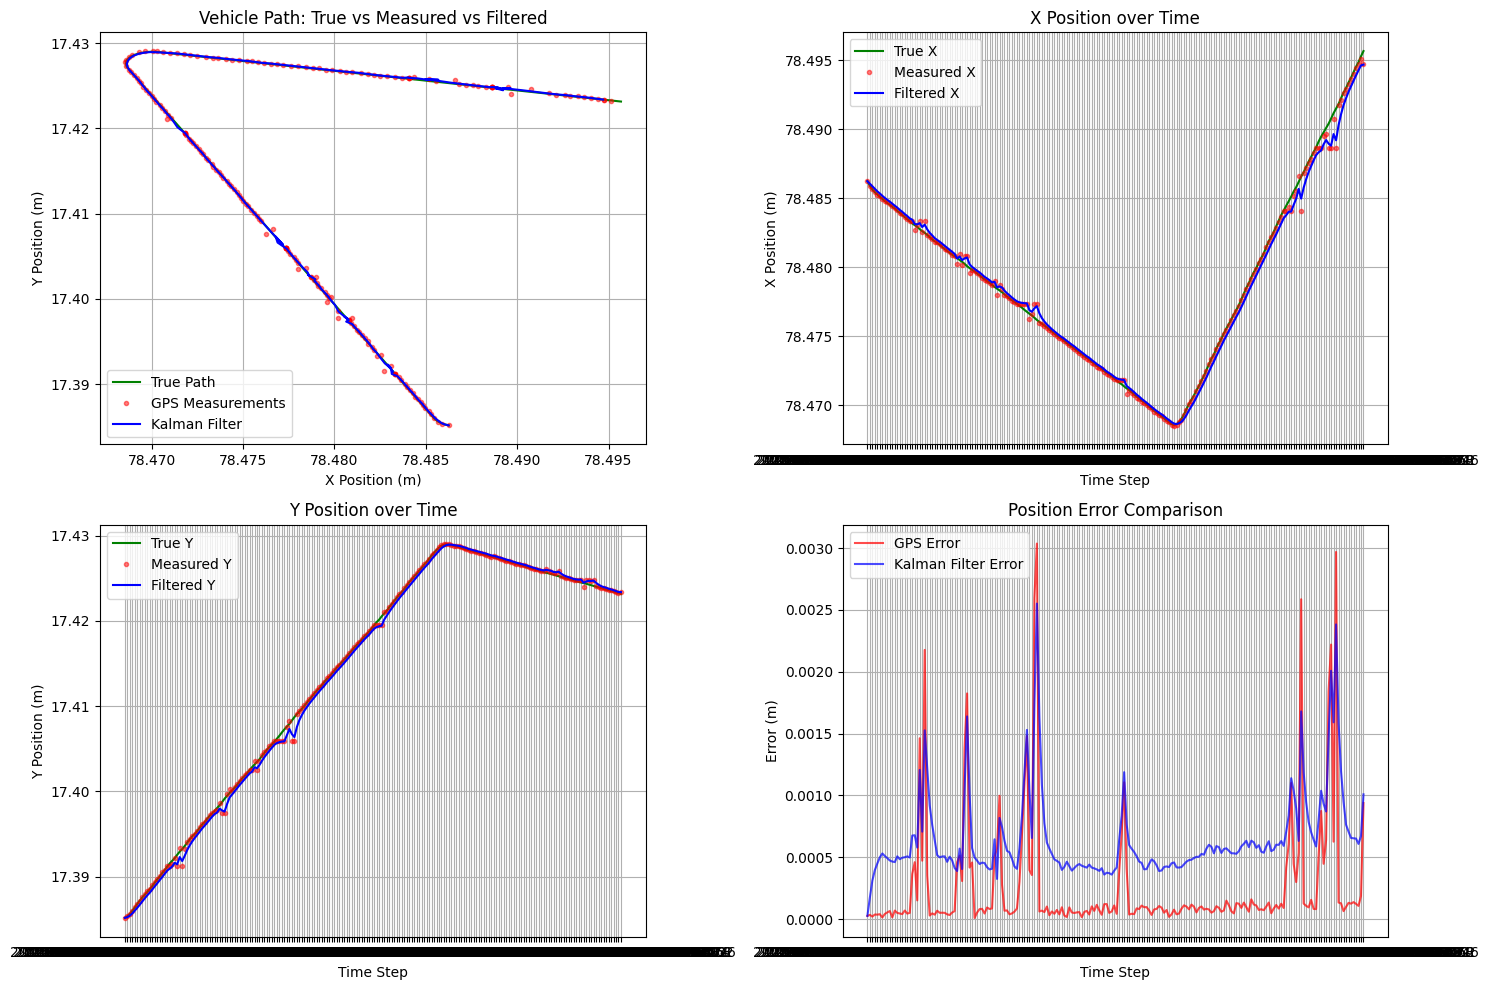

In [73]:
# Visualization
plt.figure(figsize=(15, 10))

# Plot the positions
plt.subplot(2, 2, 1)
plt.plot(data['true_longitude'], data['true_latitude'], 'g-', label='True Path')
plt.plot(data['longitude'], data['latitude'], 'r.', alpha=0.5, label='GPS Measurements')
plt.plot(filtered_x, filtered_y, 'b-', label='Kalman Filter')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Vehicle Path: True vs Measured vs Filtered')
plt.legend()
plt.grid(True)

# Plot the X position over time
plt.subplot(2, 2, 2)
plt.plot(data['timestamp'], data['true_longitude'], 'g-', label='True X')
plt.plot(data['timestamp'], data['longitude'], 'r.', alpha=0.5, label='Measured X')
plt.plot(data['timestamp'], filtered_x, 'b-', label='Filtered X')
plt.xlabel('Time Step')
plt.ylabel('X Position (m)')
plt.title('X Position over Time')
plt.legend()
plt.grid(True)

# Plot the Y position over time
plt.subplot(2, 2, 3)
plt.plot(data['timestamp'], data['true_latitude'], 'g-', label='True Y')
plt.plot(data['timestamp'], data['latitude'], 'r.', alpha=0.5, label='Measured Y')
plt.plot(data['timestamp'], filtered_y, 'b-', label='Filtered Y')
plt.xlabel('Time Step')
plt.ylabel('Y Position (m)')
plt.title('Y Position over Time')
plt.legend()
plt.grid(True)

# Plot the error comparison
plt.subplot(2, 2, 4)
plt.plot(data['timestamp'], data['measured_error'], 'r-', alpha=0.7, label='GPS Error')
plt.plot(data['timestamp'], data['filtered_error'], 'b-', alpha=0.7, label='Kalman Filter Error')
plt.xlabel('Time Step')
plt.ylabel('Error (m)')
plt.title('Position Error Comparison')
plt.legend()
plt.grid(True)

# Print average errors
avg_measured_error = data['measured_error'].mean()
avg_filtered_error = data['filtered_error'].mean()
error_reduction = (1 - avg_filtered_error/avg_measured_error) * 100

print(f"Average GPS measurement error: {avg_measured_error:.2f} meters")
print(f"Average Kalman filter error: {avg_filtered_error:.2f} meters")
print(f"Error reduction: {error_reduction:.2f}%")

plt.tight_layout()
plt.show()

#### Preview the data on Map

In [74]:
center_lat = data['filtered_y'].mean()
center_lon = data['filtered_x'].mean()


fig = px.scatter_mapbox(data,
                        lat="filtered_y",  ## Y-coord
                        lon="filtered_x", ## X-coord
                        zoom=15,
                        height=600,
                        center=dict(lat=center_lat, lon=center_lon),
                        color_discrete_sequence=["red"],
                        size_max = [0.1] * len(data))
 # Set marker size to 10 for all points


fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

#### Run Comparision Analysis between filtered and Raw

In [75]:
# prompt: overlay two dataset  on the map data['filtered_y'], data['filtered_y'] and data['latitude'], data['longitude']

import plotly.graph_objects as go # import graph_objects

center_lat = data['latitude'].mean()
center_lon = data['longitude'].mean()

fig = go.Figure(go.Scattermapbox( # Use go.Figure and go.Scattermapbox
                        lat=data['latitude'],
                        lon=data['longitude'],
                        mode='markers',
                        marker=go.scattermapbox.Marker(
                            size=13,
                            color='red'
                        ),
                        name="Original"
                    ))


fig.add_trace(go.Scattermapbox( # Use go.Scattermapbox for the second trace
                        lat=data['filtered_y'],  ## Y-coord
                        lon=data['filtered_x'], ## X-coord
                        mode='markers',
                        name="flattend",
                        marker=go.scattermapbox.Marker(
                            size=13,
                            color='blue',
                            opacity=0.5,
                        )
                    ))


fig.update_layout(
    mapbox_style="open-street-map",
    margin={"r":0,"t":0,"l":0,"b":0},
    mapbox={'center': {'lat': center_lat, 'lon': center_lon}, 'zoom': 13}, # Set center and zoom in update_layout
    height=600
)
fig.show()